In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

get_ipython().magic('matplotlib inline')

## Camera Calibration

In [2]:
def CameraCalibration(loc):
    nx = 9
    ny = 6
    images = glob.glob(loc) #"camera_cal/calibration*.jpg"
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
    for filename in images:
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)

    img_size = (img.shape[1], img.shape[0])
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


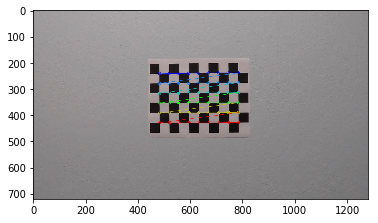

In [3]:
ret, mtx, dist, rvecs, tvecs=CameraCalibration("camera_cal/calibration*.jpg")

In [4]:
def undistort(img_, mtx_, dist_):
    return cv2.undistort(img_, mtx_, dist_, None, mtx_)


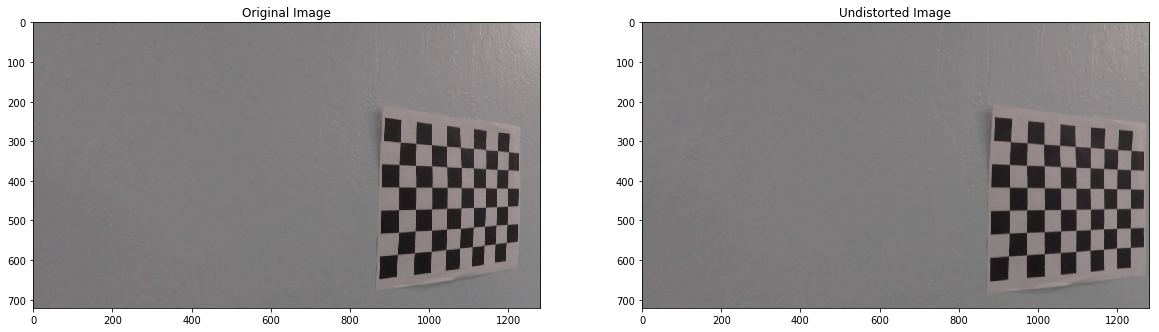

In [21]:
img = cv2.imread('camera_cal/calibration15.jpg')
img_undistort = undistort(img,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image')

## Gradient and color transforms

 The following color thresholds are used
 - R&G chaneel thresholds - for detecting yellow lines
 - L channel thresholds 
 - S channel thresholds - good job of seperating white and yellow lines

In [6]:
def ThresholdImage(img):

    img = cv2.undistort(img, mtx, dist)

    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape

    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)

    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))

    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))

    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]

    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])

    # Put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be yellow or white
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1

    # apply region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    threshold = cv2.bitwise_and(color_combined, mask)
    
    return threshold

In [7]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

In [8]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

## Binary threshold Image

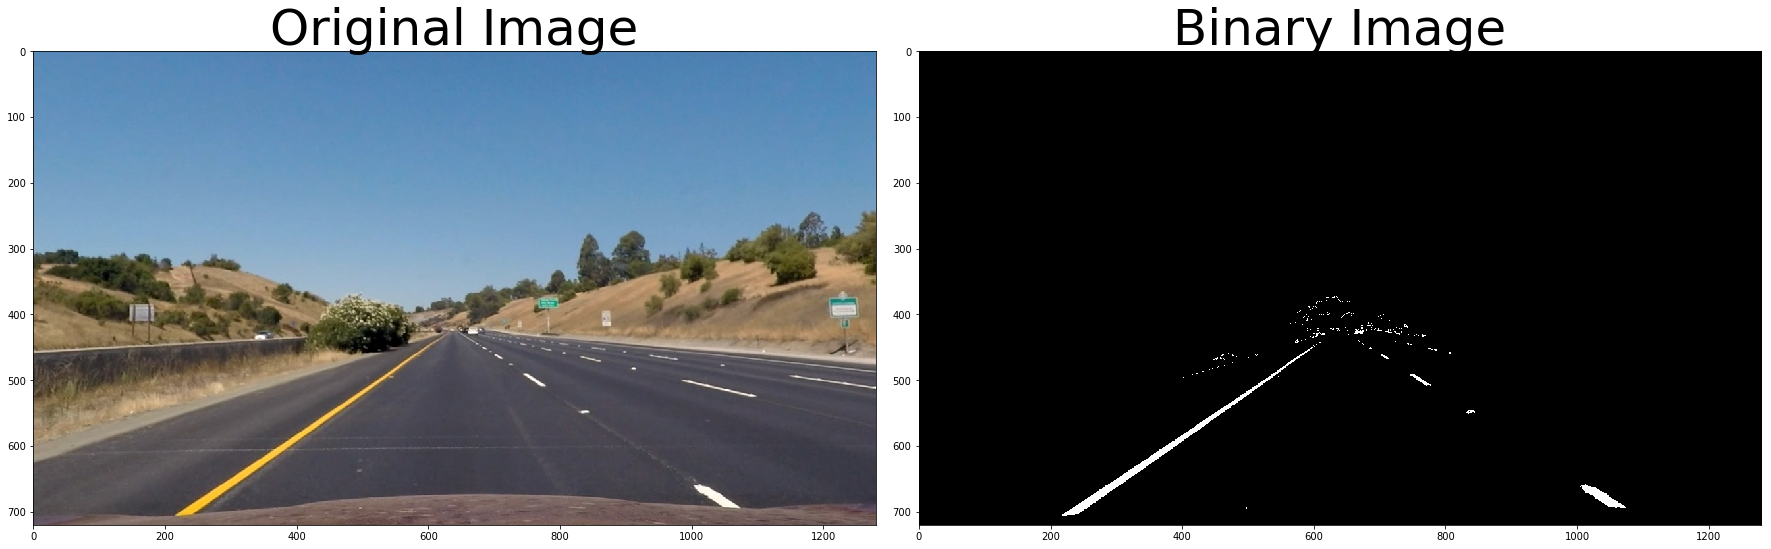

In [9]:
img = mpimg.imread('test_images/straight_lines1.jpg')
thresholded = ThresholdImage(img)
img = undistort(img,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective transform

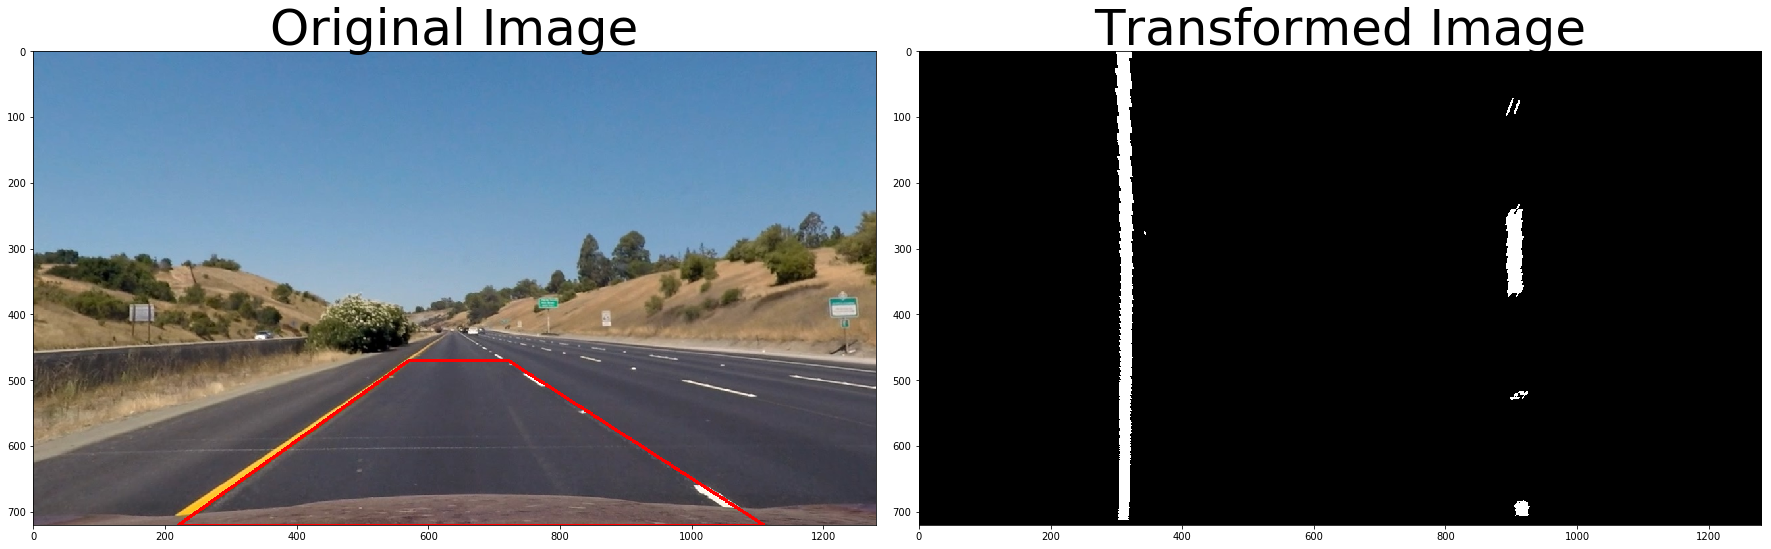

In [10]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (img.shape[1], img.shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9)


## Identifying lane pixels

Histogram - Peaks in the histogram tell us about the position of the lanes in the image

307 908


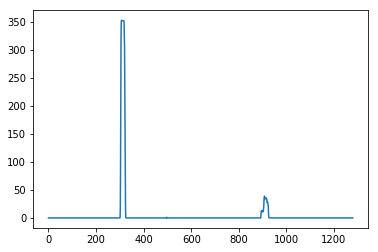

In [11]:
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)


 ## Sliding window search

(720, 0)

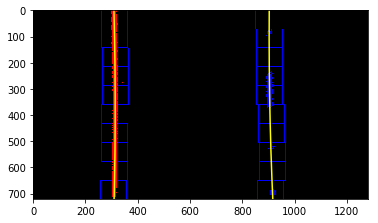

In [12]:
out_img = np.dstack((warped, warped, warped))*255
non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]
num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50
min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height 
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)
out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]
polyfit_left = np.polyfit(left_y, left_x, 2)
right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]
polyfit_right = np.polyfit(right_y, right_x, 2)
y_points = np.linspace(0, num_rows-1, num_rows)
left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

## Searching around a previously detected line

(720, 0)

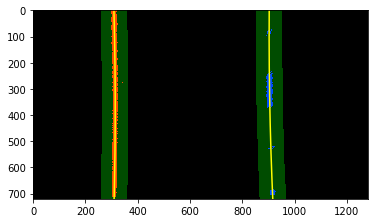

In [13]:
margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]
right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]
polyfit_left = np.polyfit(left_y, left_x, 2)
right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]
polyfit_right = np.polyfit(right_y, right_x, 2)
y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
window_img = np.zeros_like(out_img)
left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))
left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))
left_line_points = np.vstack((left_line_window_1, left_line_window_2))
cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])
right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))
right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))
right_line_points = np.vstack((right_line_window_1, right_line_window_2))
cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

 ## Computing radius of curvature and center offset

The radius of curvature is computed according to the formula as described in the classroom material. The mean of the lane pixels closest to the car gives us center of the lane. The center of the image gives us position of the car. The difference between the two is the offset from the center.

In [14]:
def RadiusOfCurvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = RadiusOfCurvature(left_x_predictions)
right_curve_rad = RadiusOfCurvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 4568.82 m
Center offset: 0.14 m


## Inverse transform

- Paint the lane area
- Perform an inverse perspective transform
- Combine the processed image with the original image

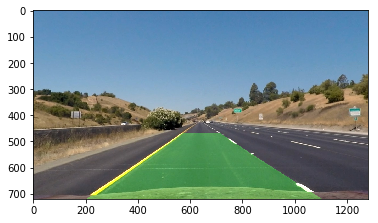

In [15]:
out_img = np.dstack((warped, warped, warped))*255
y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
plt.imshow(result)

Combining all of the above in a single pipeline

In [16]:
def Pipeline(img):
    img_shape = img.shape
    img_size = (img.shape[1], img.shape[0])
    # get thresholded image
    thresholded = ThresholdImage(img)
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    out_img = np.dstack((warped, warped, warped))*255
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)

    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    num_rows = warped.shape[0]
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50
    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height
        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width
        cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)
        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width
        cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)
        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
    out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    polyfit_left = np.polyfit(left_y, left_x, 2)
    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    polyfit_right = np.polyfit(right_y, right_x, 2)
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

    margin = 50
    out_img = np.dstack((warped, warped, warped))*255

    left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
    left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]
    right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
    right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
    out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
    out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    polyfit_left = np.polyfit(left_y, left_x, 2)
    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    polyfit_right = np.polyfit(right_y, right_x, 2)
    y_points = np.linspace(0, num_rows-1, num_rows)

    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    window_img = np.zeros_like(out_img)
    left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))
    left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))
    left_line_points = np.vstack((left_line_window_1, left_line_window_2))
    cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])
    right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))
    right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))
    right_line_points = np.vstack((right_line_window_1, right_line_window_2))
    cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


    # compute the radius of curvature
    left_curve_rad = RadiusOfCurvature(left_x_predictions)
    right_curve_rad = RadiusOfCurvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad

    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs

    out_img = np.dstack((warped, warped, warped))*255
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    return result

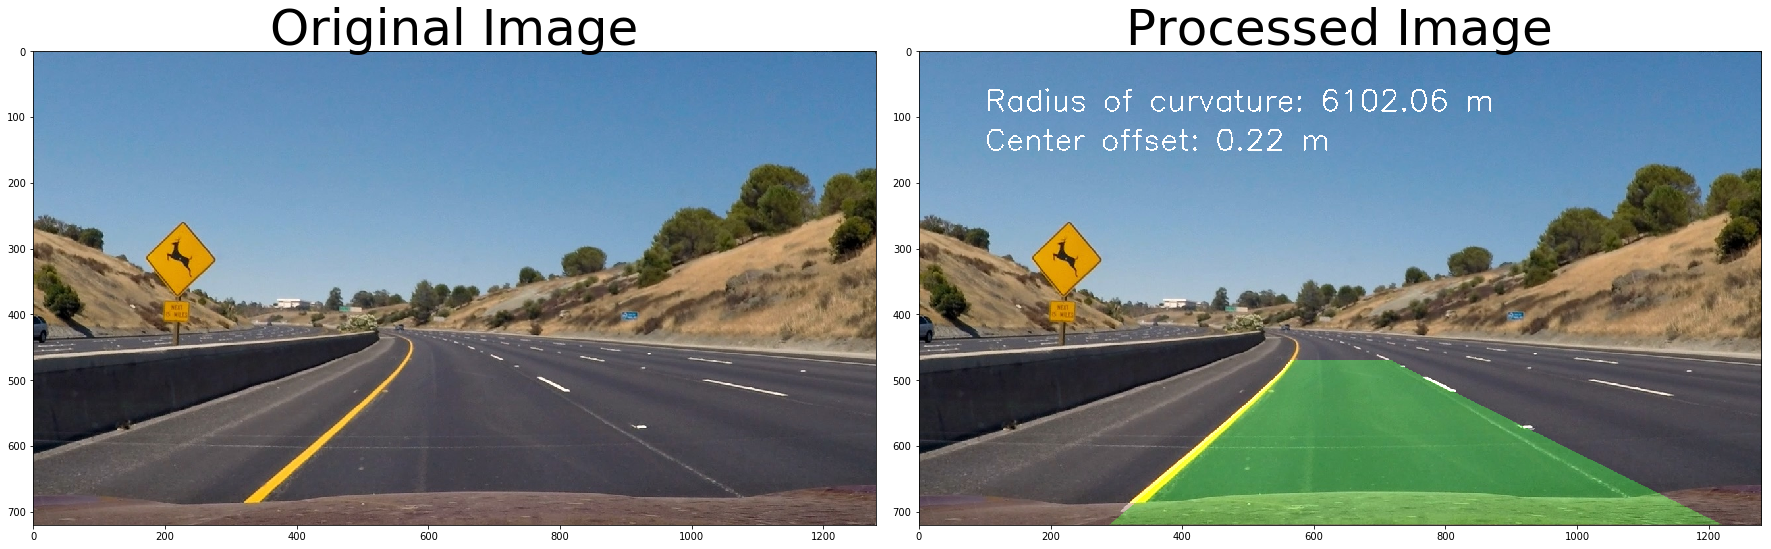

In [17]:
img = mpimg.imread('test_images/test2.jpg')
processed = Pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
output = 'ProjectVideoOutput.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
get_ipython().magic('time white_clip.write_videofile(output, audio=False)')

[MoviePy] >>>> Building video ProjectVideoOutput.mp4
[MoviePy] Writing video ProjectVideoOutput.mp4


100%|█████████▉| 1260/1261 [02:47<00:00,  7.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ProjectVideoOutput.mp4 

CPU times: user 3min, sys: 12.4 s, total: 3min 12s
Wall time: 2min 48s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Discussion

Issues and Challenges

- Selection of thresholds involved lot of iteration
- Lane lines were difficult to detect
- Short on time for exploring further 

Points of failure

- The current pipeline fails on complex cases
- Pipeline fails when the video has shadows, lane lines change color, brightness of the lanes varies

Improvement

- Code for frames where no lanes are detected . No pixels detected when using sliding window search
- Currently code runs on a single frame, averaging lane is one option which I'll explore further
- Refractor  code 